# Coastal control line construction analysis

By [Aric Chokey](http://twitter.com/aric_chokey)

Using data pulled from the Florida Department of Environmental Protection, we'll analyze the annual trends in the number of CCCL permits issed by the state since 1996.

## Load in the data

We'll pull in the data downloaded from the state's website and check out some info on the columns.

In [1]:
import pandas as pd
%matplotlib inline

cccl_permits = pd.read_csv("cleaned_permits.csv", low_memory=False)

How many approved permits are we looking at?

In [2]:
len(cccl_permits)

7834

## Sort data by year

We're looking at the "ISSUE_DATE" field, which is currently just a string. So we'll have to convert it to a datetime object to get the year.

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'

cccl_permits.ISSUE_DATE = pd.to_datetime(cccl_permits.ISSUE_DATE)

In [21]:
def get_cycle(dt):
    if dt.year % 1 == 0:
        return dt.year
    else:
        return dt.year +1

In [22]:
cccl_permits['issue_year'] = cccl_permits.ISSUE_DATE.apply(get_cycle)

In [23]:
by_year = cccl_permits.groupby("issue_year").size().reset_index()

## Plot total permits issued per year

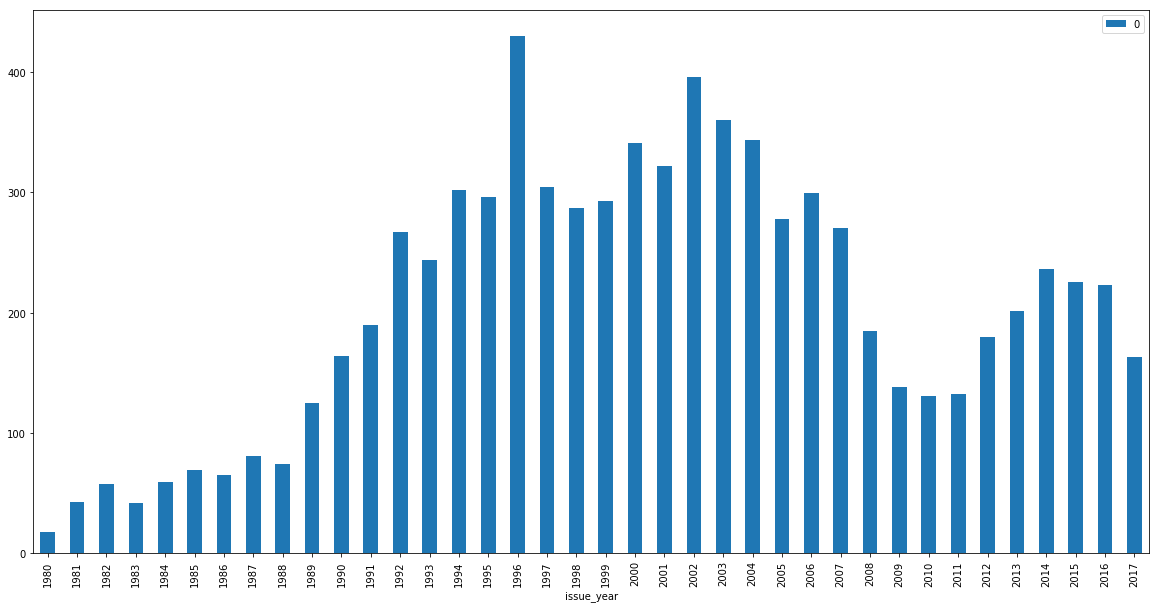

In [24]:
by_year.set_index("issue_year").plot.bar(figsize=(20, 10))

## Break down the data by location

We have an overall picture of the permits, but now we'll narrow down our data to see what the trend is by county. 

But since the only location data we have is longitude, latitude and messy address fields, we're going to have to determine the counties coordinates are located in.

For that, we'll use from [geopandas](http://geopandas.org/) to merge the coordinates with a [shapefile of Florida counties](https://github.com/SunSentinel/florida-shapefiles/blob/master/counties/florida/fl-counties.geojson).


In [28]:
import geopandas as gp
import shapely
from shapely.geometry import Point

cccl_permits['Y'] = cccl_permits.Y.apply(pd.to_numeric)
cccl_permits['X'] = cccl_permits.X.apply(pd.to_numeric)

cccl_permits['geometry'] = cccl_permits.apply(
    lambda z: Point(z.X, z.Y), axis=1
    )


permits_gdf = gp.GeoDataFrame(cccl_permits)

permits_gdf.crs
permits_gdf.crs = {'init': u'epsg:4269'}

In [29]:
permits_gdf = permits_gdf[permits_gdf.is_valid == True]

In [30]:
counties_gdf = gp.read_file("./fl-counties.geojson")

In [31]:
counties_gdf.crs

{'init': 'epsg:4269'}

In [32]:
merged_gdf = gp.sjoin(counties_gdf, permits_gdf, how="inner")
print(len(merged_gdf))

7757


In [33]:
county_counts = merged_gdf.groupby([
    "GEOID",
]).agg(dict(ISSUE_DATE="count")).reset_index()

In [34]:
county_counts.columns = ['GEOID', 'ISSUED']

In [35]:
county_counts_gdf = counties_gdf.merge(county_counts, on="GEOID", how="left")

In [73]:
county_counts_gdf[[
    'GEOID',
    'NAME',
    'ISSUED',
]].sort_values("ISSUED", ascending=False).head(25)

,GEOID,NAME,ISSUED
36,12131,Walton,611.0
42,12071,Lee,565.0
45,12115,Sarasota,546.0
25,12037,Franklin,481.0
44,12109,St. Johns,447.0
16,12045,Gulf,435.0
23,12009,Brevard,425.0
46,12005,Bay,412.0
51,12081,Manatee,390.0
57,12061,Indian River,376.0


/Users/achokey/Documents/GitHub/projects/venv/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


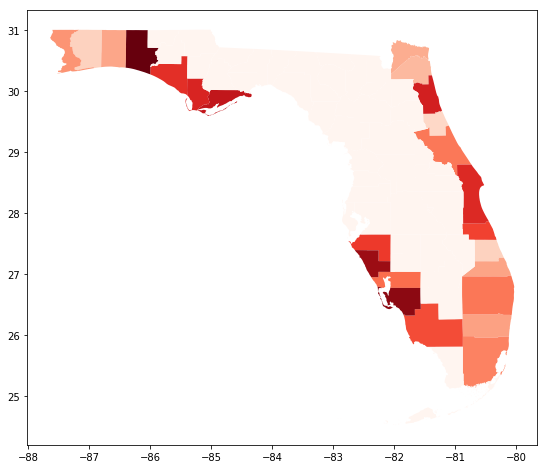

In [66]:
county_counts_gdf.sort_values("ISSUED", ascending=True).plot(
    column="ISSUED",
    cmap='Reds',
    figsize=(16,8)
)

## Plot yearly counts for Palm Beach County

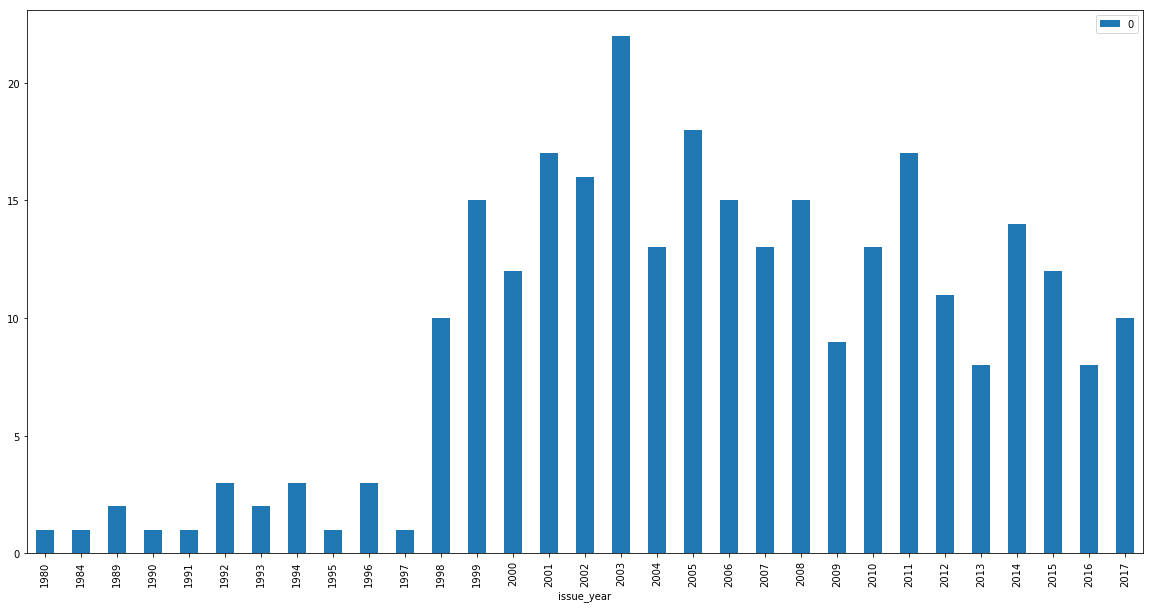

In [77]:
# Filter by county name.
pbc_permits = merged_gdf[merged_gdf.NAME == "Palm Beach"]

# Group data by the year.
pbc_by_year = pbc_permits.groupby("issue_year").size().reset_index()

# Then plot it.
pbc_by_year.set_index("issue_year").plot.bar(figsize=(20, 10))

## Plot yearly counts for Broward County

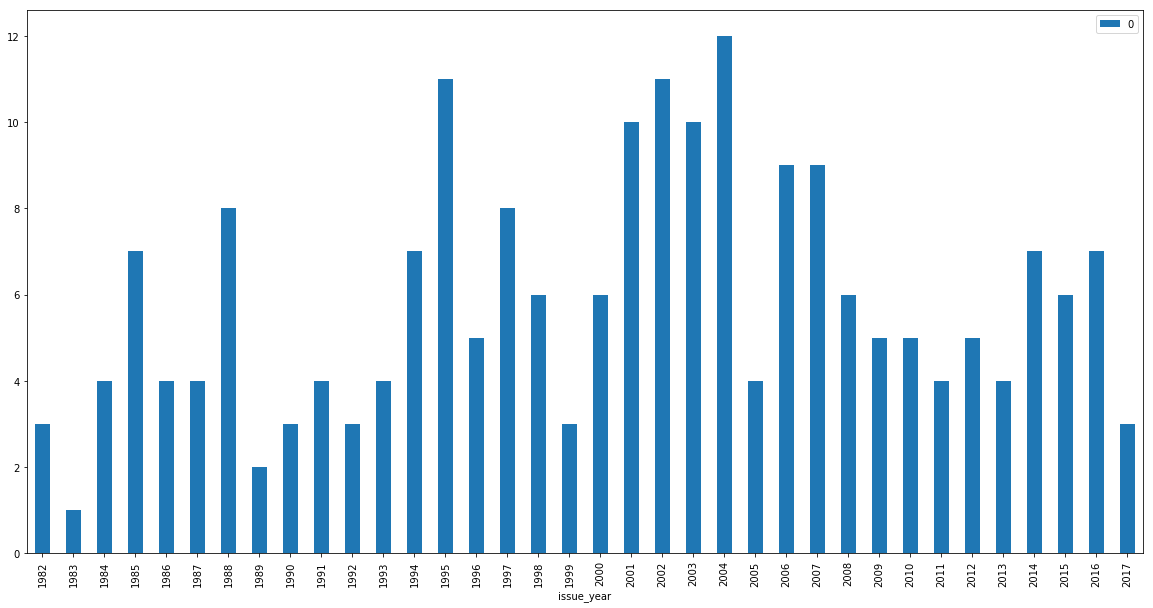

In [72]:
# Filter by county name.
br_permits = merged_gdf[merged_gdf.NAME == "Broward"]

# Group data by the year.
br_by_year = pbc_permits.groupby("issue_year").size().reset_index()

# Then plot it.
br_by_year.set_index("issue_year").plot.bar(figsize=(20, 10))

## Plot yearly counts for Miami-Dade County

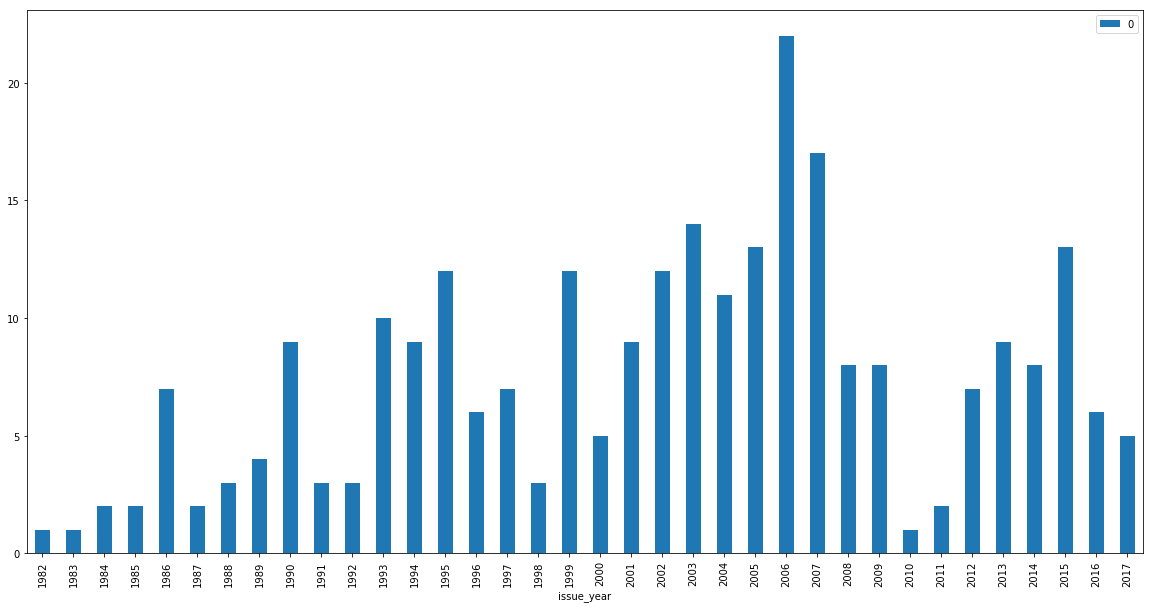

In [74]:
# Filter by county name.
md_permits = merged_gdf[merged_gdf.NAME == "Miami-Dade"]

# Group data by the year.
md_by_year = pbc_permits.groupby("issue_year").size().reset_index()

# Then plot it.
md_by_year.set_index("issue_year").plot.bar(figsize=(20, 10))